In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer,Reshape, Bidirectional, LSTM, BatchNormalization
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt



In [2]:
# Load the data
x_train = pd.read_csv(r"/kaggle/input/hijja-dataset/train_X.csv", header=None)
y_train = pd.read_csv(r"/kaggle/input/hijja-dataset/train_Y.csv", header=None)
x_test = pd.read_csv(r"/kaggle/input/hijja-dataset/test_X.csv", header=None)
y_test = pd.read_csv(r"/kaggle/input/hijja-dataset/test_Y.csv", header=None)

# Reshape the data
x_train = x_train.values.reshape(-1, 32, 32, 1) / 255.0
x_test = x_test.values.reshape(-1, 32, 32, 1) / 255.0

# Convert labels to categorical
total_classes = len(np.unique(y_train)) + 1
y_train = to_categorical(y_train, total_classes)
y_test = to_categorical(y_test, total_classes)



In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Bidirectional, LSTM, Reshape


# Custom Layer for Neutrosophic Transformation
class NeutrosophicTransformation(layers.Layer):
    def __init__(self, **kwargs):
        super(NeutrosophicTransformation, self).__init__(**kwargs)
    
    def call(self, inputs):
        T = inputs
        I = 0.1 * tf.random.uniform(shape=tf.shape(inputs))  # Create indeterminacy component
        F = 1 - T - I  # Create falsity component
        return T, I, F

    def compute_output_shape(self, input_shape):
        return [input_shape, input_shape, input_shape]

# Custom Neutrosophic Layer
class NeutrosophicLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(NeutrosophicLayer, self).__init__(**kwargs)
    
    def call(self, inputs):
        T, I, F = inputs
        # Concatenate T, I, and F along the channel axis
        return tf.concat([T, I, F], axis=-1)
    
    def compute_output_shape(self, input_shape):
        # Compute the output shape after concatenation
        # input_shape is a list of 3 tensors with shapes [(batch_size, height, width, channels), ...]
        shape = list(input_shape[0])  # Take the shape of T (or I, or F)
        shape[-1] *= 3  # Multiply the number of channels by 3
        return tuple(shape)

# Build the model with neutrosophic layers
def build_model_neutrosophic(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Convert inputs to neutrosophic numbers using the custom layer
    T, I, F = NeutrosophicTransformation()(inputs)
    
    # Apply neutrosophic processing using another custom layer
    x = NeutrosophicLayer()([T, I, F])
    
    # Continue with the rest of the model
    x = Conv2D(64, (3, 3), padding='valid', activation='relu',strides=1,
            kernel_initializer='HeNormal')(x)
    x = Conv2D(64, (3, 3), padding='valid', activation='relu',strides=1)(x)
    x = MaxPooling2D((2, 2),strides=1)(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(128, (3, 3), padding='valid', activation='relu',strides=1)(x)
    x = MaxPooling2D((2, 2),strides=1)(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(128, (3, 3), padding='valid', activation='relu',strides=1)(x)
    x = MaxPooling2D((2, 2),strides=1)(x)
    x = BatchNormalization()(x)
    
     # Reshape to prepare for GRU layers
    x = layers.Lambda(lambda t: tf.reshape(t, (-1, t.shape[1] * t.shape[2], t.shape[3])))(x)
    
    x = BatchNormalization()(x)
    # Stacking 4 Bi-GRU layers
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Bidirectional(LSTM(32, return_sequences=False))(x)
    
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    outputs = Dense(30, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model

# Build and compile the model
model = build_model_neutrosophic((32, 32, 1))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Assuming x_train, y_train, x_test, y_test are already defined and preprocessed
# Train the model
history = model.fit(x_train, y_train, batch_size=64, epochs=200, validation_data=(x_test, y_test))

# Evaluate the model
model.evaluate(x_test, y_test, verbose=2)

# Make predictions
y_held_pred = model.predict(x_test)
y_pred = np.argmax(y_held_pred, axis=1)
y_test_1 = np.argmax(y_test, axis=1)

# Display the evaluation metrics
from sklearn.metrics import classification_report
print(classification_report(y_test_1, y_pred))

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ neutrosophic_trans… │ [(None, 32, 32,   │          0 │ input_layer[0][0] │
│ (NeutrosophicTrans… │ 1), (None, 32,    │            │                   │
│                     │ 32, 1), (None,    │            │                   │
│                     │ 32, 32, 1)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ neutrosophic_layer  │ (None, 32, 32, 3) │          0 │ neutrosophic_tra… │
│ (NeutrosophicLayer) │                   │            │ neutrosophic_tra… │
│                     │                   │            │ neutrosophic_tra… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      1,792 │ neutrosophic_lay… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 27, 27,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 27, 27,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 25, 25,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 24, 24,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 22, 22,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 21, 21,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 21,    │        512 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 441, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 441, 128)  │        512 │ lambda[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 441, 512)  │    788,480 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                 

 Total params: 2,501,726 (9.54 MB)

 Trainable params: 2,500,830 (9.54 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
593/593 ━━━━━━━━━━━━━━━━━━━━ 158s 249ms/step - accuracy: 0.1410 - loss: 2.8277 - val_accuracy: 0.1677 - val_loss: 2.8948
Epoch 2/200
593/593 ━━━━━━━━━━━━━━━━━━━━ 148s 250ms/step - accuracy: 0.4543 - loss: 1.6990 - val_accuracy: 0.4036 - val_loss: 2.0443
Epoch 3/200
593/593 ━━━━━━━━━━━━━━━━━━━━ 148s 250ms/step - accuracy: 0.6364 - loss: 1.1326 - val_accuracy: 0.6858 - val_loss: 0.9903
Epoch 4/200
593/593 ━━━━━━━━━━━━━━━━━━━━ 148s 250ms/step - accuracy: 0.7574 - loss: 0.7728 - val_accuracy: 0.2089 - val_loss: 3.4485
Epoch 5/200
593/593 ━━━━━━━━━━━━━━━━━━━━ 148s 250ms/step - accuracy: 0.8127 - loss: 0.5996 - val_accuracy: 0.8148 - val_loss: 0.6042
Epoch 6/200
593/593 ━━━━━━━━━━━━━━━━━━━━ 148s 250ms/step - accuracy: 0.8574 - loss: 0.4601 - val_accuracy: 0.8376 - val_loss: 0.5448
Epoch 7/200
593/593 ━━━━━━━━━━━━━━━━━━━━ 148s 250ms/step - accuracy: 0.8767 - loss: 0.4009 - val_accuracy: 0.8497 - val_loss: 0.5114
Epoch 8/200
593/593 ━━━━━━━━━━━━━━━━━━━━ 148s 250ms/step - accuracy: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from keras.activations import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,LSTM,GRU
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score, f1_score ,confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC, ConfusionMatrix


In [4]:
y_held_pred=model.predict(x_test)

y_pred=np.argmax(y_held_pred, axis=1)
y_test_1=np.argmax(y_test, axis=1)

print(y_test_1.shape)
print(y_pred.shape)

297/297 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step
(9501,)
(9501,)


In [5]:
model.evaluate(x_test,y_test)

297/297 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - accuracy: 0.9238 - loss: 0.5801


[0.663989245891571, 0.9109567403793335]

In [6]:
his=model.evaluate(x_test, y_test, verbose=2);
print(his)

297/297 - 18s - 60ms/step - accuracy: 0.9122 - loss: 0.6642
[0.6642107367515564, 0.912219762802124]


In [7]:
y_held_pred_train=model.predict(x_train)

y_pred_train=np.argmax(y_held_pred_train, axis=1)
y_train_1=np.argmax(y_train, axis=1)

print(y_train_1.shape)
print(y_pred_train.shape)
model.evaluate(x_train, y_train, verbose=2);

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 72s 60ms/step
(37933,)
(37933,)
1186/1186 - 71s - 60ms/step - accuracy: 0.9938 - loss: 0.0206


In [8]:
# Make predictions
y_held_pred = model.predict(x_test)
y_pred = np.argmax(y_held_pred, axis=1)
y_test_1 = np.argmax(y_test, axis=1)



297/297 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step


<Axes: title={'center': 'Actual vs. Predicted'}, xlabel='Actual G*', ylabel='Predicted G*'>

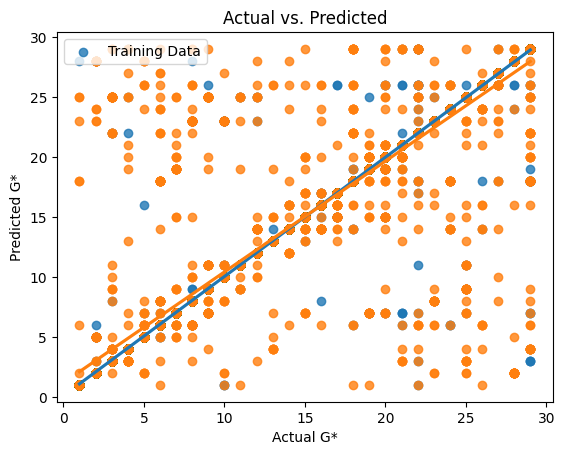

In [9]:
import seaborn as sns

sns.regplot(x=y_train_1,y=y_pred_train, label="Training Data")

plt.xlabel('Actual G*')
plt.ylabel('Predicted G*')
plt.title('Actual vs. Predicted')
plt.legend(loc="upper left")

sns.regplot(x=y_test_1,y=y_pred, label="Testing Data")

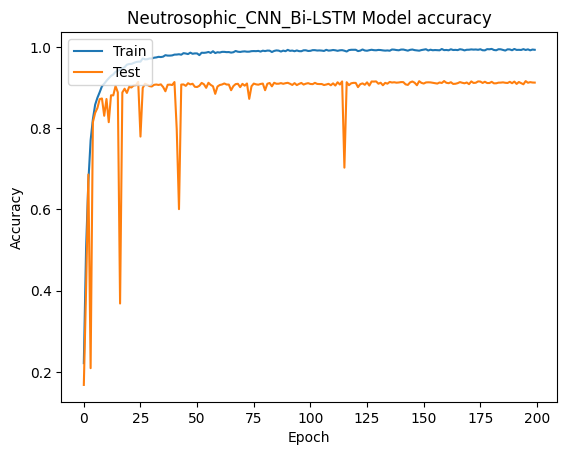

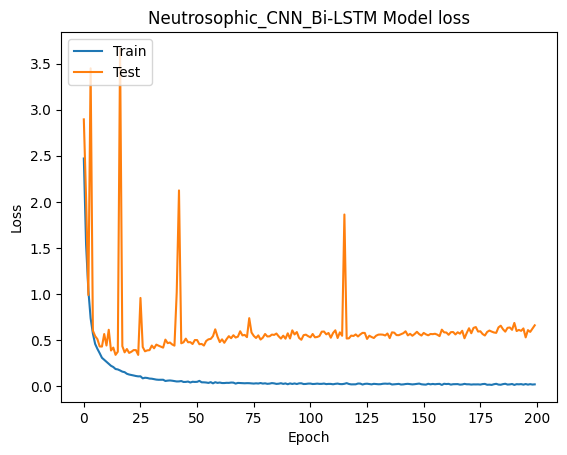

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Neutrosophic_CNN_Bi-LSTM Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Neutrosophic_CNN_Bi-LSTM Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [11]:
y_predicted = model.predict(x_test)
y_grand_truth = y_test
y_predicted = np.argmax(y_predicted,axis=1)
y_grand_truth = np.argmax(y_grand_truth,axis=1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_grand_truth, y_predicted)

297/297 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step


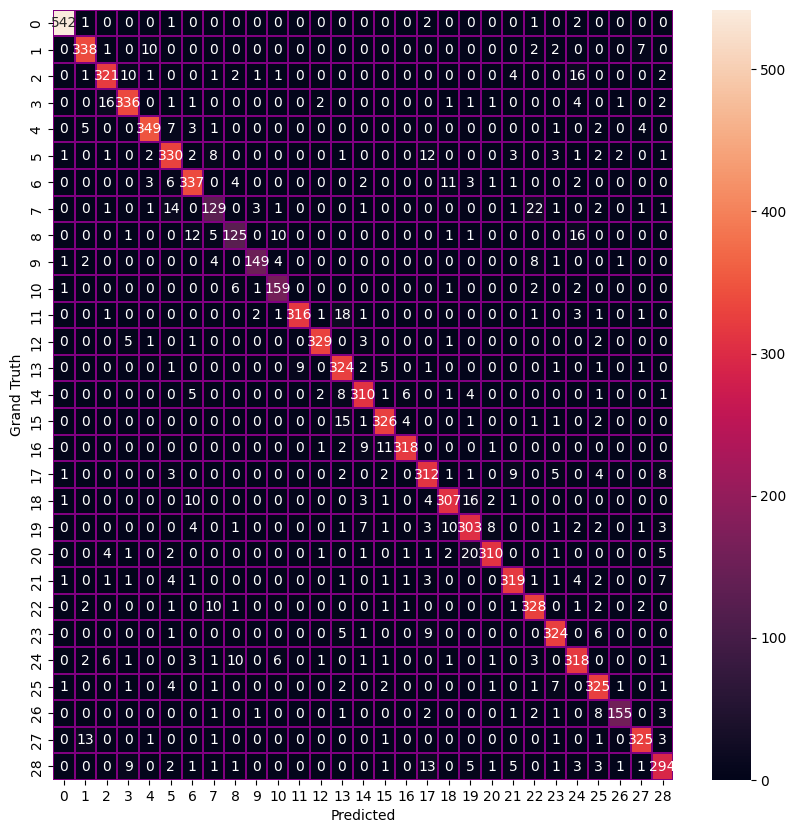

In [12]:
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm,fmt=".0f", annot=True,linewidths=0.1, linecolor="purple", ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Grand Truth")
plt.show()

In [ ]:
scores = np.zeros((29,3))
def calc_F1(num):
  TP = cm[num,num]
  FN = np.sum(cm[num,:])-cm[num,num]
  FP = np.sum(cm[:,num])-cm[num,num]
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  F1_score = 2*(recall * precision) / (recall + precision)
  return precision, recall, F1_score
for i in range(29):
   precision, recall, F1_score = calc_F1(i)
   scores[i,:] = precision, recall, F1_score
scores_frame = pd.DataFrame(scores,columns=["Precision", "Recall", "F1 Score"], index=[list(range(0, 29))])

In [ ]:
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score, f1_score ,confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC, ConfusionMatrix

# Functions: Performance Evaluation 

def Performance(Model , y_predd): 
    
    # model accuracy
    accuracy = accuracy_score(y_test_1, y_predd)
    print( Model +' Accuracy:'+'\033[1m {:.2f}%'.format(accuracy*100))
    
    # model Classification Report
    print('\nClassification Report: '+'\033[0m')
    print('*' * 22)
    print(classification_report(y_test_1, y_predd))

In [ ]:
Performance('Neutrosophic_CNN_Bi-LSTM' , y_pred)